<a href="https://colab.research.google.com/github/Sweta-Das/Creating_Multitask_Models_Using_Keras/blob/main/Creating_Multi_task_Models_using_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Creating Multi-task Models using Keras


In [ ]:
%matplotlib inline
%load_ext tensorboard

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import shutil # Shutil = Shell Utilities; Higher level file operations

try:
  shutil.rmtree('logs') 
  # deletes an entire directory tree; Syntax: shutil.rmtree(path, ignore_errors=False, onerror=None)
  # Path points to a dir. If ignore_errors=True, errors due to failed removals will be ignored. If ignore_errors=False, errors are handled by handler specified
  # by onerror, or if omitted, it raises an exception.
except:
  pass

Task - 1: Creating a dataset

In [ ]:
# Using Keras Dataset to download MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


We are not going to use MNIST dataset directly, we're going to synthesize new dataset from it.

In [ ]:
def create_example(x, y):  # here, x= image of mnist dataset; y=label of mnist dataset
  c = np.random.randint(0, 2) # randomly either c = 0 or 1
  image = 0.5 * np.random.rand(28, 28, 3) # for colored label, 28*28 = mnist dataset & 3 signify RGB color
  image[:, :, c] += 0.5 * x / 255.  # This'll show mnist example value only for Red & Green color.
  return image, y, c 

digit: 1, color: red


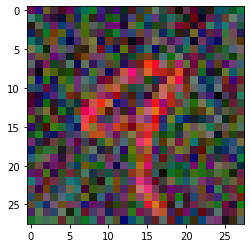

In [ ]:
# Dictionary to keep track of color labels
colors = {0: 'red', 1: 'green'}

x, y, c = create_example(x_train[4], y_train[8])
print(f'digit: {y}, color: {colors[c]}') # displaying digit with its color

plt.imshow(x)
plt.show()

Task - 2: Dataset Generator

In [ ]:
# For training & testing the dataset
def generate_data(x, y, batch_size: 32):
  num_examples = len(y) # total number of examples = length of labels/examples

  # For generator
  while True: 
    x_batch = np.zeros((batch_size, 28, 28, 3))
    y_batch = np.zeros((batch_size,)) # y ranges 0-9
    c_batch = np.zeros((batch_size,)) # c ranges 0-1 (Red/Green)

    for i in range(0, batch_size):
      